In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.spatial.distance import cdist 
import main

1. Generate distribution with Mitchell algorithm

In [9]:
r = 1           # circle radius
grid = [100, 100]
width, height = grid

m = 2           # number of starting points
N = 1024         # number of all points

In [10]:
## Selects two random points on a grid
initial = np.array([ [random.uniform(0,1)*width, random.uniform(0,1)*height] for i in range(m) ])

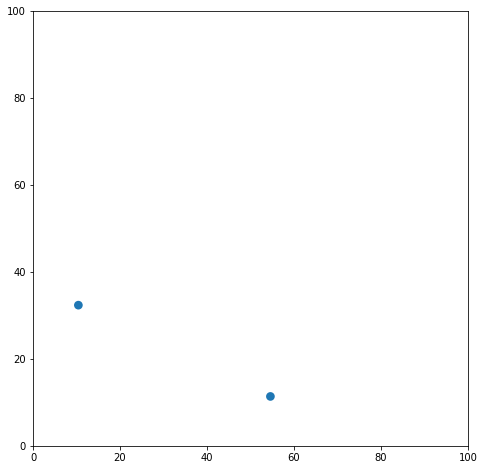

In [11]:
plt.figure(figsize=(8,8))

for center in initial:
    circle = plt.Circle(center, radius=r)
    plt.gca().add_patch(circle)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
plt.show()

In [12]:
## now generate distribution with Mitchell algorithm
dist = main.distribution(initial, grid, N)
#display(dist.samples)

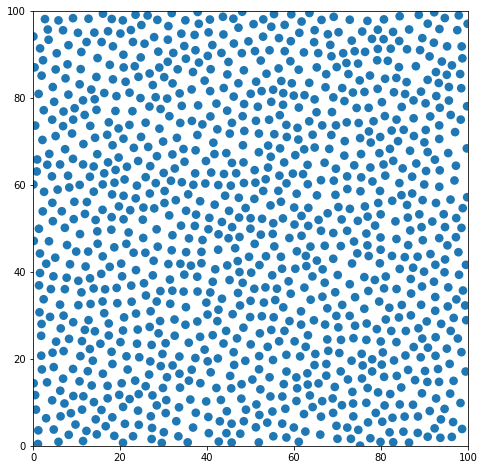

In [14]:
plt.figure(figsize=(8,8))

for center in dist.samples:
    circle = plt.Circle(center, radius=r)
    plt.gca().add_patch(circle)

    print(center[0], center[1], sep='\t', file=open('../gnuplot/porazdelitev_1024.txt', 'a'))

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
plt.show()

____
2. Turn points into ellipses with random orientations

In [7]:
a, eps = 5, math.sqrt(21)/5         # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)           # small semi-axis
a_width, b_height = 2*a, 2*b        # small and big semi-axis for patches

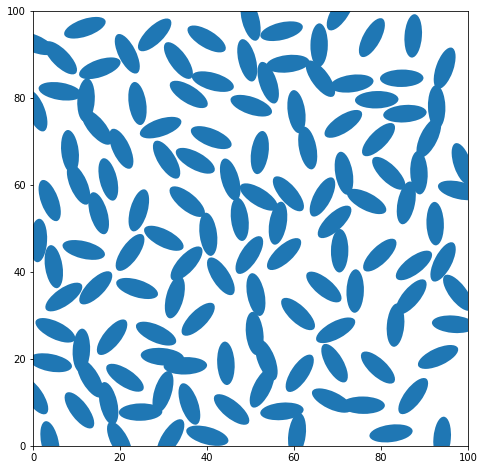

In [8]:
## generate ellipses
plt.figure(figsize=(8,8))

new_dist = main.ellipses(dist, a, b)

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()


_____
3. Wertheim-Perram contact function

In [9]:
## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance = cdist(S, S, dist.periodic_metric)

## matrix of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*a) & (line!=0)) for line in distance]

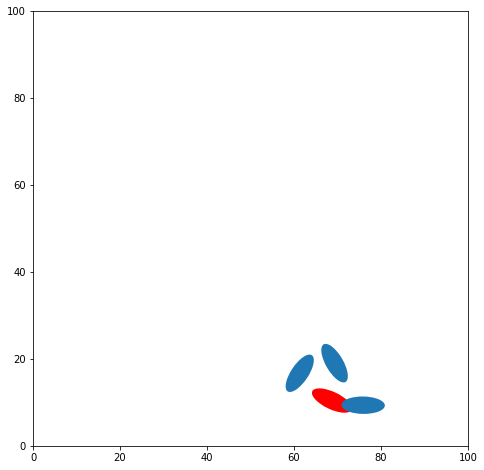

In [10]:
plt.figure(figsize=(8,8))

## select ellipse 'i' and check its proximity
i = random.randint(0,N-1)

i_ellipse = new_dist.ell[i]

plt.axes()
ell_patch = main.ellipse.convert_to_patches(i_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')

i_neighbourhood = new_dist.ell[in_proximity[i]]
for E in i_neighbourhood:
    ell_patch = main.ellipse.convert_to_patches(E, a_width, b_height)
    plt.gca().add_patch(ell_patch)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
plt.show()

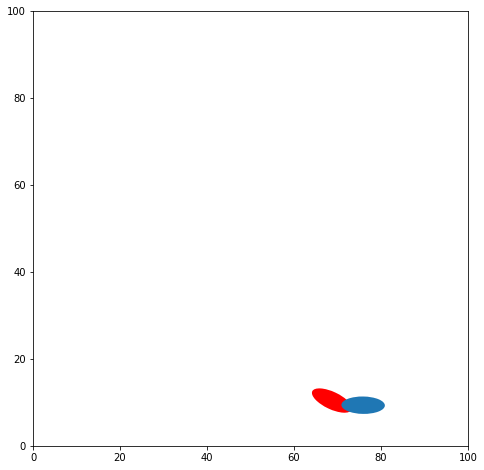

In [11]:
plt.figure(figsize=(8,8))

## display only those ellipses that are touching or overlapping i-th ellipse
close = np.array([new_dist.mu(i_ellipse, neighbour) for neighbour in i_neighbourhood])

ell_patch = main.ellipse.convert_to_patches(i_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')

## the ones that have mu < 1 are overlapping
in_contact = i_neighbourhood[np.where(close<1)]
for E in in_contact:
    ell_patch = main.ellipse.convert_to_patches(E, a_width, b_height)
    plt.gca().add_patch(ell_patch)


plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
plt.show()

___
4. Von Mises-Fisher distribution

In [12]:
mu, kappa = 0.0, 3        # mean and dispersion
s = np.random.vonmises(mu, kappa, 1000)

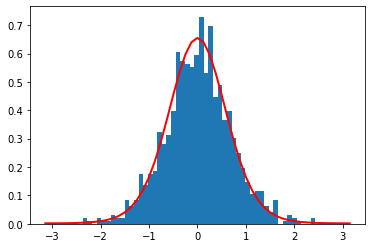

In [13]:
from scipy.special import i0
plt.hist(s, 50, density=True)
x = np.linspace(-math.pi, math.pi, num=51)
y = np.exp(kappa*np.cos(x-mu))/(2*np.pi*i0(kappa))
plt.plot(x, y, linewidth=2, color='r')
plt.show()

___
5. growth and rotation

In [14]:
## start with small ellipses
a, eps = 4, 2/3                 # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)       # small semi-axis
a_width, b_height = 2*a, 2*b    # small and big semi-axis for patches

## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance = cdist(S, S, dist.periodic_metric)

## matrix of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*a) & (line!=0)) for line in distance]

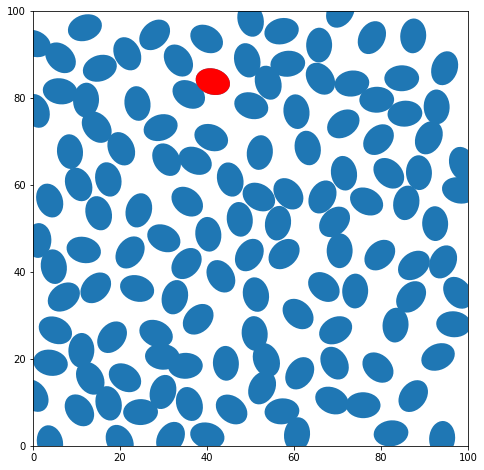

In [15]:
## generate ellipses
plt.figure(figsize=(8,8))

## select random ellipse
j = random.randint( 0, N-1 )

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

j_ellipse = new_dist.ell[j]

ell_patch = main.ellipse.convert_to_patches(j_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()

In [16]:
## rotate random ellipse by random angle
theta = np.random.vonmises(new_dist.ell[j].angle, kappa)
new_dist.ell[j].angle = theta

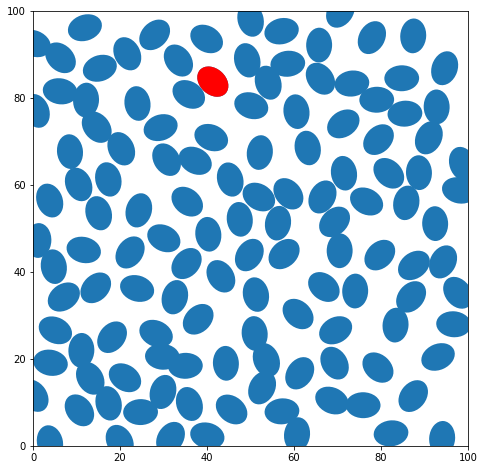

In [17]:
## generate ellipses
plt.figure(figsize=(8,8))

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

j_ellipse = new_dist.ell[j]

ell_patch = main.ellipse.convert_to_patches(j_ellipse, a_width, b_height)
plt.gca().add_patch(ell_patch)
ell_patch.set_facecolor('r')


plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()